# Dark Channel Prior

In [1]:
import math
import numpy as np
import pandas as pd
import cv2
import time
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

In [2]:
class Node(object):
    def __init__(self,x,y,value):
        self.x = x
        self.y = y
        self.value = value

    def printInfo(self):
        print('%s:%s:%s' %(self.x,self.y,self.value))

In [3]:
#check if image shape is fine i.e. there are 3 channels
#returns min of three channels
def getMinChannel(img):
    '''gets min in val in differnt channel
    Parameters:
        img(numpy array): input image
    Returns:
        min in three channels'''
    if len(img.shape)==3 and img.shape[2]==3:
        pass
    else:
        print("bad image shape, input must be color image")
        return None
    
    return np.min(img, axis=2)

In [7]:
def getDarkChannel(img,blockSize = 3):
    '''
    Gets dark channel
    Parameters:
        image(numpy array): Input image
        blockSize(int):neighbourhood Refered to as omega in paper
    Return:
        image:Dark channel only one channel
    '''
    
    if len(img.shape)==2:
        pass
    else:
        print("bad image shape, input image must be two demensions")
        return None

    
    if blockSize % 2 == 0 or blockSize < 3:
        print('blockSize is not odd or too small')
        return None

    
    A = int((blockSize-1)/2) #Define increments around centre of the block

    #New height and new width
    H = img.shape[0] + blockSize - 1
    W = img.shape[1] + blockSize - 1

    #define padding
    imgMiddle = 255 * np.ones((H,W))    

    imgMiddle[A:H-A, A:W-A] = img
    
    imgDark = np.zeros_like(img, np.uint8)    
    
    localMin = 255
    #define neighbourhood
    for i in range(A, H-A):
        for j in range(A, W-A):
            x = range(i-A, i+A+1)
            y = range(j-A, j+A+1)
            #defines darkest pix in neighbourhood
            imgDark[i-A,j-A] = np.min(imgMiddle[x,y])                            
            
    return imgDark


In [8]:
def getAtomsphericLight(darkChannel,img,meanMode = False, percent = 0.001):
    '''
    Gets estimate for for factor A in transmission map
    Parameters:
        darkChannel(1-D numpy array): Dark channel obtained from getDarkChannel()
        img(3-d numpy array): input image
        percent(float): percent of pixels to be considered for A calculation
    Returns atmosphericLight(float): value of term A
    '''
    size = darkChannel.shape[0]*darkChannel.shape[1]
    height = darkChannel.shape[0]
    width = darkChannel.shape[1]

    nodes = []

    #list of pixel location and darkchannel intensity location
    for i in range(0,height):
        for j in range(0,width):
            oneNode = Node(i,j,darkChannel[i,j])
            nodes.append(oneNode)	

    #sort nodes in descending order of dark channel intensity
    nodes = sorted(nodes, key = lambda node: node.value,reverse = True)

    atomsphericLight = 0

    # top value of img as atmospheric light
    if int(percent*size) == 0:
        for i in range(0,3):
            if img[nodes[0].x,nodes[0].y,i] > atomsphericLight:
                atomsphericLight = img[nodes[0].x,nodes[0].y,i]
        return atomsphericLight

    
    if meanMode:
        sum = 0
        for i in range(0,int(percent*size)):
            for j in range(0,3):
                sum = sum + img[nodes[i].x,nodes[i].y,j]
        atomsphericLight = int(sum/(int(percent*size)*3))
        return atomsphericLight

   
    for i in range(0,int(percent*size)):
        for j in range(0,3):
            if img[nodes[i].x,nodes[i].y,j] > atomsphericLight:
                atomsphericLight = img[nodes[i].x,nodes[i].y,j]
    return atomsphericLight


In [9]:
def getRecoverScene(img, omega=0.95, t0=0.1, blockSize=15, meanMode=False, percent=0.001, refine=False):
    '''
    get recovered scene from dark channel prior
    Parameters:
        img(3d numpy array): input image
        omega(float): for incomplete haze removal to aid in depth perception
        t0(float): lower bount for t
        blocksize(int): neighbourhood size
        percent: number of pixeks to consider for Atmosheric light determination
    Return:
    sceneRadiance(3 d numpy array): recovered image
    '''
    imgGray = getMinChannel(img)
    imgDark = getDarkChannel(imgGray, blockSize = blockSize)
    atomsphericLight = getAtomsphericLight(imgDark,img,meanMode = meanMode,percent= percent)

    imgDark = np.float64(imgDark)
    transmission = 1 - omega * imgDark / atomsphericLight

    transmission[transmission<0.1] = 0.1     
    
    if refine:        
        normI = (img - img.min()) / (img.max() - img.min())  # normalize I
        transmission = guided_filter(normI, transmission, r=40, eps=1e-3)

    sceneRadiance = np.zeros(img.shape)
    img = np.float64(img)
    
    for i in range(3):        
        SR = (img[:,:,i] - atomsphericLight)/transmission + atomsphericLight

                        
        SR[SR>255] = 255
        SR[SR<0] = 0                    
        sceneRadiance[:,:,i] = SR  
            
    sceneRadiance = np.uint8(sceneRadiance)

    return sceneRadiance

In [10]:
"""Implementation for Guided Image Filtering
Reference:
http://research.microsoft.com/en-us/um/people/kahe/eccv10/
"""

from itertools import combinations_with_replacement
from collections import defaultdict

import numpy as np
from numpy.linalg import inv

R, G, B = 0, 1, 2  # index for convenience


def boxfilter(I, r):
    """Fast box filter implementation.
    Parameters
    ----------
    I:  a single channel/gray image data normalized to [0.0, 1.0]
    r:  window radius
    Return
    -----------
    The filtered image data.
    """        
    M, N = I.shape
    dest = np.zeros((M, N))

    # cumulative sum over Y axis
    sumY = np.cumsum(I, axis=0)
    # difference over Y axis
    dest[:r + 1] = sumY[r: 2 * r + 1]
    dest[r + 1:M - r] = sumY[2 * r + 1:] - sumY[:M - 2 * r - 1]
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2 * r - 1:M - r - 1]

    # cumulative sum over X axis
    sumX = np.cumsum(dest, axis=1)
    # difference over Y axis
    dest[:, :r + 1] = sumX[:, r:2 * r + 1]
    dest[:, r + 1:N - r] = sumX[:, 2 * r + 1:] - sumX[:, :N - 2 * r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - \
        sumX[:, N - 2 * r - 1:N - r - 1]

    return dest


def guided_filter(I, p, r=40, eps=1e-3):
    """Refine a filter under the guidance of another (RGB) image.
    Parameters
    -----------
    I:   an M * N * 3 RGB image for guidance.
    p:   the M * N filter to be guided
    r:   the radius of the guidance
    eps: epsilon for the guided filter
    Return
    -----------
    The guided filter.
    """    
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r)

    # each channel of I filtered with the mean filter
    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]
    # p filtered with the mean filter
    mean_p = boxfilter(p, r) / base
    # filter I with p then filter it with the mean filter
    means_IP = [boxfilter(I[:, :, i] * p, r) / base for i in range(3)]
    # covariance of (I, p) in each local patch
    covIP = [means_IP[i] - means[i] * mean_p for i in range(3)]

    # variance of I in each local patch: the matrix Sigma in ECCV10 eq.14
    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(
            I[:, :, i] * I[:, :, j], r) / base - means[i] * means[j]

    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        #         rr, rg, rb
        # Sigma = rg, gg, gb
        #         rb, gb, bb
        Sigma = np.array([[var[R][R][y, x], var[R][G][y, x], var[R][B][y, x]],
                          [var[R][G][y, x], var[G][G][y, x], var[G][B][y, x]],
                          [var[R][B][y, x], var[G][B][y, x], var[B][B][y, x]]])
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, inv(Sigma + eps * np.eye(3)))  # eq 14

    # ECCV10 eq.15
    b = mean_p - a[:, :, R] * means[R] - \
        a[:, :, G] * means[G] - a[:, :, B] * means[B]

    # ECCV10 eq.16
    q = (boxfilter(a[:, :, R], r) * I[:, :, R] + boxfilter(a[:, :, G], r) *
         I[:, :, G] + boxfilter(a[:, :, B], r) * I[:, :, B] + boxfilter(b, r)) / base

    return q

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


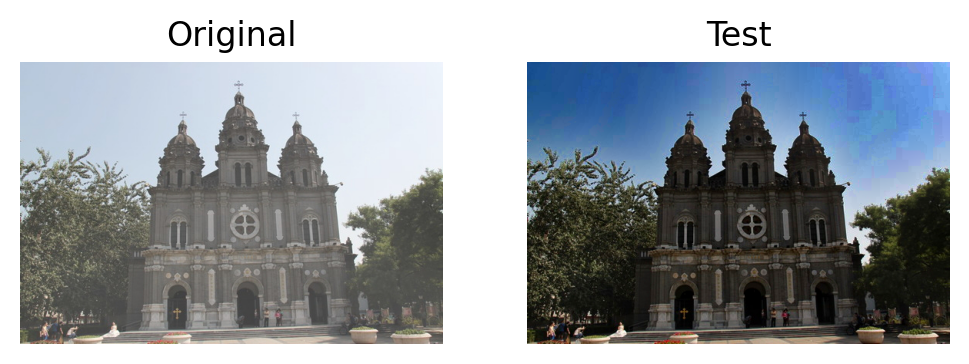

In [11]:
def sample():
    url="https://raw.githubusercontent.com/abubakrsiddq/ImageDehazing/main/sampleImg/hazy/1982_1_0.08.jpg"
    image = io.imread(url) 
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #img = cv2.imread('./hazy/0001_0.8_0.2.jpg',cv2.IMREAD_COLOR)
    sceneRadiance = getRecoverScene(img,refine=True)
    
    plt.rcParams['figure.dpi'] = 200
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(sceneRadiance, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Test")
    #cv2.imshow('original',img)
    #cv2.imshow('test',sceneRadiance)
    #cv2.waitKey(0)
    #cv2.destroyAllWindow

In [39]:
import tensorflow as tf
import glob
import os
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    return np.array(img)

In [40]:
def evaluate_gen():
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/ohaze/hazy/*.jpg')
    #random.shuffle(test_img)
    i=1;
    print('[',end='')
    for img in test_img:
        
        img=load_image(img)
        print("=",end='')
        sc=getRecoverScene(img,refine=True)
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        
        directory = '/content/drive/MyDrive/Test/dcp'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, sc)

        os.chdir('/content')
        i+=1;
    print(']',end='')

In [41]:
evaluate_gen()

[=============================================]

In [28]:
sceneRadiance = getRecoverScene(i,refine=True)

In [23]:
url="https://raw.githubusercontent.com/abubakrsiddq/ImageDehazing/main/sampleImg/hazy/1982_1_0.08.jpg"
image = io.imread(url) 

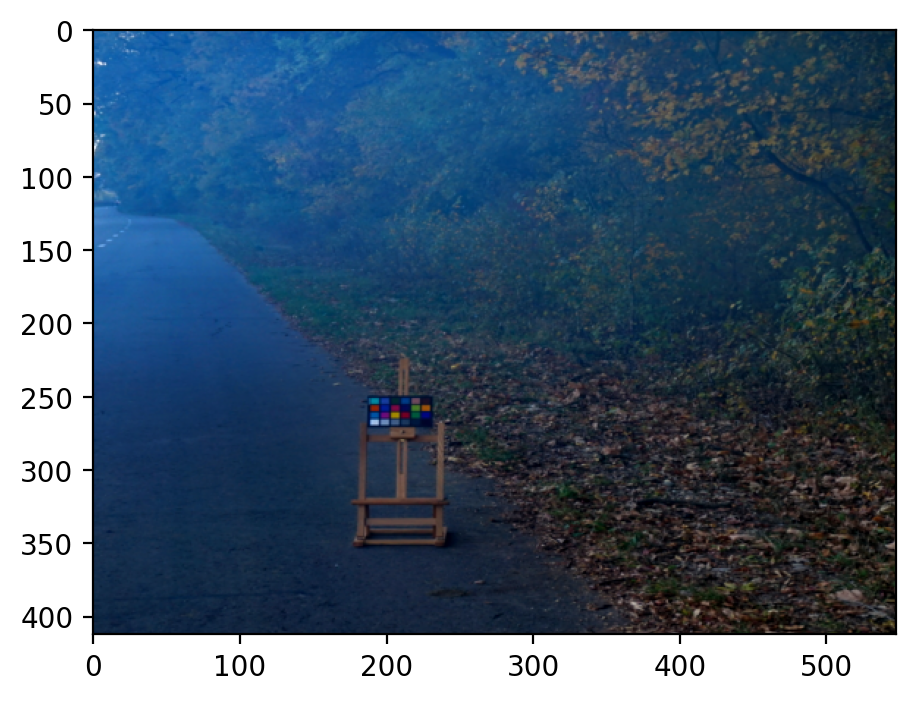

In [29]:
plt.imshow(sceneRadiance)